# Hiring Decision Tree Case Study with GridSearchCV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

plt.style.use('ggplot')

df = pd.read_csv('hiredata.csv')
df.head()

,YearsExperience,EducationLevel,SkillsScore,CertificationCount,Hired
0,6,High School,88,0,0
1,3,High School,50,3,0
2,12,PhD,78,2,1
3,14,Post-Graduate,63,3,1
4,10,High School,99,3,1


## Handle Missing Values (if any)

In [2]:
df.isnull().sum()
df = df.fillna(df.median(numeric_only=True))
df.isnull().sum()

YearsExperience       0
EducationLevel        0
SkillsScore           0
CertificationCount    0
Hired                 0
dtype: int64

## Encode Categorical Column

In [3]:
le = LabelEncoder()
df['EducationLevelEncoded'] = le.fit_transform(df['EducationLevel'])
df.head()

,YearsExperience,EducationLevel,SkillsScore,CertificationCount,Hired,EducationLevelEncoded
0,6,High School,88,0,0,2
1,3,High School,50,3,0,2
2,12,PhD,78,2,1,3
3,14,Post-Graduate,63,3,1,4
4,10,High School,99,3,1,2


## Exploratory Data Analysis

In [4]:
df.describe()

,YearsExperience,SkillsScore,CertificationCount,Hired,EducationLevelEncoded
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,6.952500,69.496667,3.456667,0.412500,1.980833
std,4.378686,17.345192,2.267688,0.492489,1.408469
min,0.000000,40.000000,0.000000,0.000000,0.000000
25%,3.000000,55.000000,2.000000,0.000000,1.000000
50%,7.000000,69.000000,3.000000,0.000000,2.000000
75%,11.000000,84.000000,5.000000,1.000000,3.000000
max,14.000000,99.000000,7.000000,1.000000,4.000000


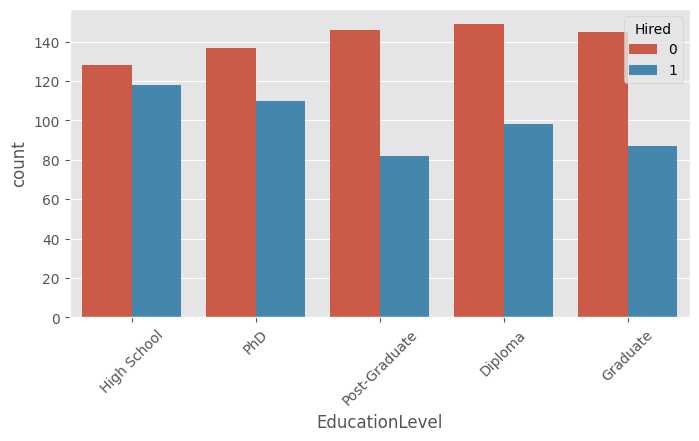

In [5]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='EducationLevel', hue='Hired')
plt.xticks(rotation=45)
plt.show()

## Train-Test Split

In [6]:
X = df[['YearsExperience','EducationLevelEncoded','SkillsScore','CertificationCount']]
y = df['Hired']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## GridSearchCV for Best Decision Tree

In [7]:
params = {
    'criterion': ['gini','entropy'],
    'max_depth': [2,3,4,5,6,7,8],
    'min_samples_split': [2,4,6,8,10]
}

grid = GridSearchCV(DecisionTreeClassifier(), params, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

grid.best_params_, grid.best_score_

({'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2},
 0.9458333333333332)

## Train Final Model

In [8]:
model = grid.best_estimator_
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

Accuracy: 0.9291666666666667
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       145
           1       0.93      0.88      0.91        95

    accuracy                           0.93       240
   macro avg       0.93      0.92      0.93       240
weighted avg       0.93      0.93      0.93       240



## Confusion Matrix

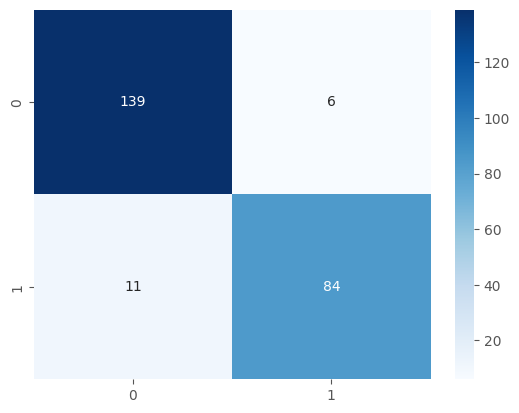

In [9]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()

## Feature Importance

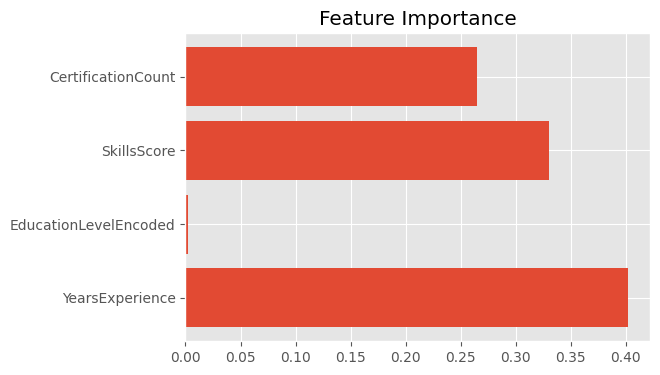

In [10]:
plt.figure(figsize=(6,4))
plt.barh(X.columns, model.feature_importances_)
plt.title("Feature Importance")
plt.show()

### Decision Tree Visualization

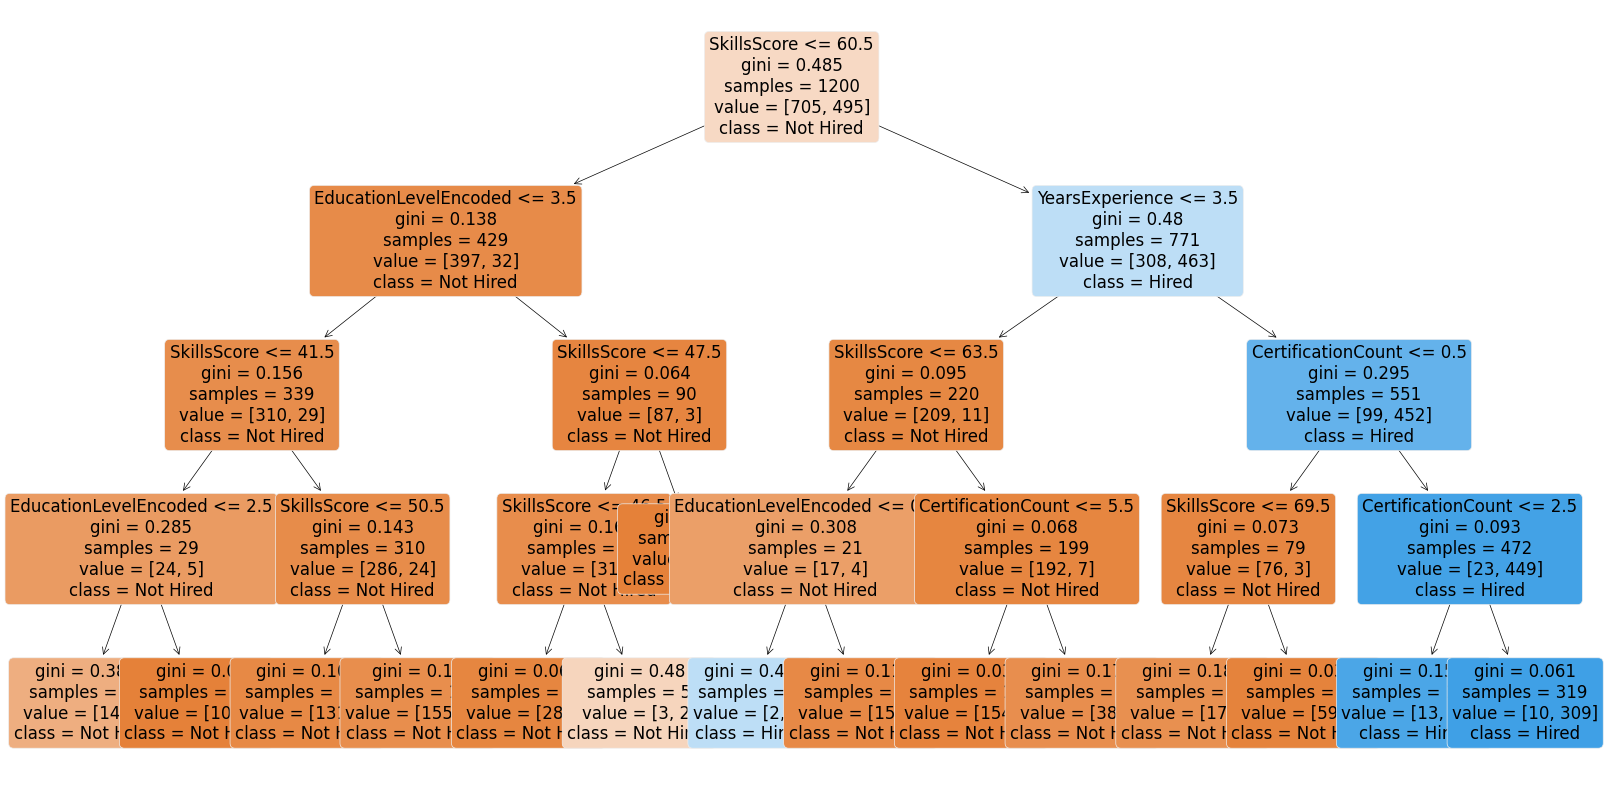

In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Train the model
model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(X, y)

# Plot the tree
plt.figure(figsize=(20,10))
plot_tree(model,
          feature_names=['YearsExperience','EducationLevelEncoded','SkillsScore','CertificationCount'],
          class_names=['Not Hired','Hired'],
          filled=True,
          rounded=True,
          fontsize=12)
plt.show()


In [12]:
import pickle

# Save the trained model
pickle.dump(model, open("hiring_decision_tree_model.pkl", "wb"))

print("Model saved as hiring_decision_tree_model.pkl")


Model saved as hiring_decision_tree_model.pkl


### Add a Prediction Function (User Input → Model Output)

- This function takes candidate details and returns Hired / Not Hired.

In [13]:
def predict_hiring(years_exp, education_level, skills_score, cert_count):
    # Encode education level
    education_encoded = le.transform([education_level])[0]
    
    # Prepare input row
    input_data = pd.DataFrame([{
        "YearsExperience": years_exp,
        "EducationLevelEncoded": education_encoded,
        "SkillsScore": skills_score,
        "CertificationCount": cert_count
    }])
    
    # Predict
    pred = model.predict(input_data)[0]
    proba = model.predict_proba(input_data)[0]
    
    return {
        "Prediction": "Hired" if pred == 1 else "Not Hired",
        "Probability_Not_Hired": round(proba[0], 3),
        "Probability_Hired": round(proba[1], 3)
    }

# Example usage:
predict_hiring(5, "Graduate", 78, 2)


{'Prediction': 'Hired',
 'Probability_Not_Hired': 0.085,
 'Probability_Hired': 0.915}

In [14]:
### Add Code to Load the Pickle File Later
loaded_model = pickle.load(open("hiring_decision_tree_model.pkl", "rb"))

# Test prediction
predict_hiring(6, "Post-Graduate", 85, 3)


{'Prediction': 'Hired',
 'Probability_Not_Hired': 0.031,
 'Probability_Hired': 0.969}